<a href="https://colab.research.google.com/github/YoshifumiMiyagi/VinDr-PCXR/blob/main/VinDr_PCXR_vol_3(feature_selection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

はじめに：特徴量を絞り込むことを特徴量選択(Feature selection)という。今回は37の特徴量を5～8個に絞り込む。Hold out法での絞り込みでは汎用性が乏しいので、cross-validationを組み込んだFeature selectionでRobustに重要な特徴量を探し出す。Feature selectionにはFilter method, Wrapper method, Embedded methodの大きく3種類が存在する。

結果：XGBoostと用いたSHAPでの37→5の絞り込みがAUC 0.855→0.825とある程度性能を維持しつつ有用だと判断される。Filter methodでも同様の5つが有用であった。

重要な特徴量は、

・Bronchial thickening（気管支肥厚）

・Consolidation（コンソリデーション）

・Peribronchovascular interstitial opacity（気管支血管周囲間質性の透過性低下）

・Reticulonodular opacity（網状結節性の透過性低下）

・Lung hyperinflation（肺の過膨張）

結語：急性呼吸器疾患（気管支肺炎、気管支炎、細気管支炎、肺炎）において、上記５つの所見は細分化をする上で重要視される。

In [ ]:
SEED=42
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize,LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import KFold, StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc, classification_report, make_scorer,RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler,PowerTransformer, label_binarize
from sklearn.multiclass import OneVsRestClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
annotation = pd.read_csv('/content/drive/MyDrive/annotations_train.csv')
annotation_test = pd.read_csv('/content/drive/MyDrive/annotations_test.csv')
annotation.head()

,image_id,rad_ID,class_name,x_min,y_min,x_max,y_max,class_id
0,03d56a9709a81b2e9d6afbc6647c8730,R3,Boot-shaped heart,378.760010,401.416645,835.143248,661.678438,0
1,48f7ba0b0fd5ab847ee87df2aed5cfc9,R3,Peribronchovascular interstitial opacity,247.196368,412.000819,441.763442,830.320028,1
2,48f7ba0b0fd5ab847ee87df2aed5cfc9,R3,Peribronchovascular interstitial opacity,613.631024,364.980443,902.238850,827.077243,1
3,74f8648d742bbcce79d67c967de5552d,R3,Peribronchovascular interstitial opacity,1008.515903,665.439667,1324.430364,1265.465119,1
4,74f8648d742bbcce79d67c967de5552d,R3,Peribronchovascular interstitial opacity,453.015307,635.756429,724.404911,1242.142575,1


In [ ]:
ohe = OneHotEncoder(sparse=False)
df_new = pd.DataFrame(ohe.fit_transform(annotation.loc[:,"class_name"].values.reshape(-1, 1)),
                      columns=ohe.get_feature_names_out(),
                      index = annotation['image_id'],
                      dtype=np.int8)
df_new.columns = ['_'.join(col.split('_')[1:]) for col in df_new.columns]
A = df_new.groupby(level=0).sum()

df_new_test = pd.DataFrame(ohe.transform(annotation_test.loc[:,"class_name"].values.reshape(-1, 1)),
                      columns=ohe.get_feature_names_out(),
                      index = annotation_test['image_id'],
                      dtype=np.int8)
df_new_test.columns = ['_'.join(col.split('_')[1:]) for col in df_new.columns]
A_test = df_new_test.groupby(level=0).sum()

label = pd.read_csv('/content/drive/MyDrive/image_labels_train.csv')
label_test = pd.read_csv('/content/drive/MyDrive/image_labels_test.csv')

label4 = label[(label['Bronchitis']==1)|(label['Brocho-pneumonia']==1)|(label['Bronchiolitis']==1)|(label['Pneumonia']==1)].loc[:,['image_id','Bronchitis','Brocho-pneumonia','Bronchiolitis','Pneumonia']]
label_test4 = label_test[(label_test['Bronchitis']==1)|(label_test['Brocho-pneumonia']==1)|(label_test['Bronchiolitis']==1)|(label_test['Pneumonia']==1)].loc[:,['image_id','Bronchitis','Brocho-pneumonia','Bronchiolitis','Pneumonia']]

df_label = label4.iloc[:,1:].idxmax(axis=1)
df = pd.concat([label4.iloc[:,0],df_label],axis=1)
df.columns = ['image_id','class_name']

df_label_test = label_test4.iloc[:,1:].idxmax(axis=1)
df_test = pd.concat([label_test4.iloc[:,0],df_label_test],axis=1)
df_test.columns = ['image_id','class_name']

Df = pd.merge(A,df,on='image_id',how='inner') # train_test_dataset
Df_test = pd.merge(A_test,df_test,on='image_id',how='inner') # validation_dataset
Df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,image_id,Anterior mediastinal mass,Aortic enlargement,Atelectasis,Boot-shaped heart,Bronchectasis,Bronchial thickening,Calcification,Cardiomegaly,Chest wall mass,...,Other opacity,Paraveterbral mass,Peribronchovascular interstitial opacity,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Reticulonodular opacity,Stomach on the right side,class_name
0,0008e7acbcdf2fedd05cc236e5594074,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,Brocho-pneumonia
1,008000749ecc9074e80562f9f90091fd,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,Bronchiolitis
2,00e5c7c8c64dcf9c2b85f2d92d67a1e3,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,Bronchiolitis
3,00e898fc3a6a95d56510c5c87fdbc03a,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,Brocho-pneumonia
4,01010180f98c184adc806d3bb53dd8e1,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,Bronchitis


In [ ]:
le = LabelEncoder()

X_, y_ = Df.iloc[:,1:-1].values, le.fit_transform(Df["class_name"])
X_val, y_val = Df_test.iloc[:,1:-1].values, le.transform(Df_test["class_name"])

X_.shape, X_val.shape, y_.shape, y_val.shape

((2157, 37), (409, 37), (2157,), (409,))

# Filter method (37→5 narrow down)

In [ ]:
n_classes = 4

In [ ]:
from sklearn.feature_selection import SelectKBest
pipe_LR =  make_pipeline(StandardScaler(),PowerTransformer(),SelectKBest(k=5),LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))
cv = KFold(n_splits=5,shuffle=True,random_state=SEED)

In [ ]:
pipe_LR.fit(X_,y_)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 1  6  8 15 17 20 24 25 29 34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('selectkbest', SelectKBest(k=5)),
                ('logisticregression',
                 LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))])

In [ ]:
selector = pipe_LR.named_steps['selectkbest']
selected_features = selector.get_feature_names_out(Df.columns[1:-1])
print(selected_features)

['Bronchial thickening' 'Consolidation' 'Lung hyperinflation'
 'Peribronchovascular interstitial opacity' 'Reticulonodular opacity']


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 1  6  8 15 17 20 24 25 29 34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


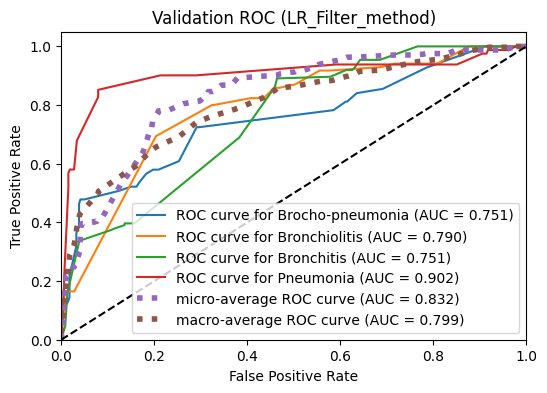

In [ ]:
classifier = pipe_LR
y_score = classifier.fit(X_, y_).predict_proba(X_val)

label_binarizer = LabelBinarizer().fit(y_)
y_onehot_test = label_binarizer.transform(y_val)

fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC (LR_Filter_method)')
plt.legend(loc="lower right")
plt.show()

macro AUC 0.841→0.799

# Wrapper method (37→6 narrow down)

In [ ]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=LogisticRegression(C=0.1, penalty='l1', solver='liblinear'), step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_, y_)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', Df.iloc[:,1:-1].columns[rfecv.support_])

Optimal number of features : 6
Best features : Index(['Bronchial thickening', 'Consolidation', 'Diffuse aveolar opacity',
       'Lung hyperinflation', 'Other opacity',
       'Peribronchovascular interstitial opacity'],
      dtype='object')


In [ ]:
X_rfecv = rfecv.transform(X_)
X_val_rfecv = rfecv.transform(X_val)

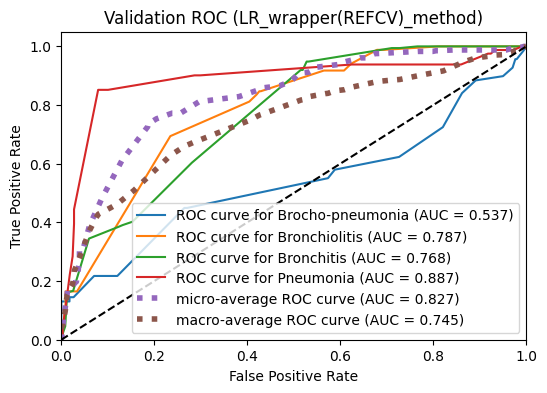

In [ ]:
classifier = pipe_LR
y_score = classifier.fit(X_rfecv, y_).predict_proba(X_val_rfecv)

label_binarizer = LabelBinarizer().fit(y_)
y_onehot_test = label_binarizer.transform(y_val)

fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC (LR_wrapper_method (REFCV))')
plt.legend(loc="lower right")
plt.show()

# Embedded method (LASSO) (37→8 narrow down)

In [ ]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5)
model =lasso_cv.fit(X_, y_)
model

LassoCV(cv=5)

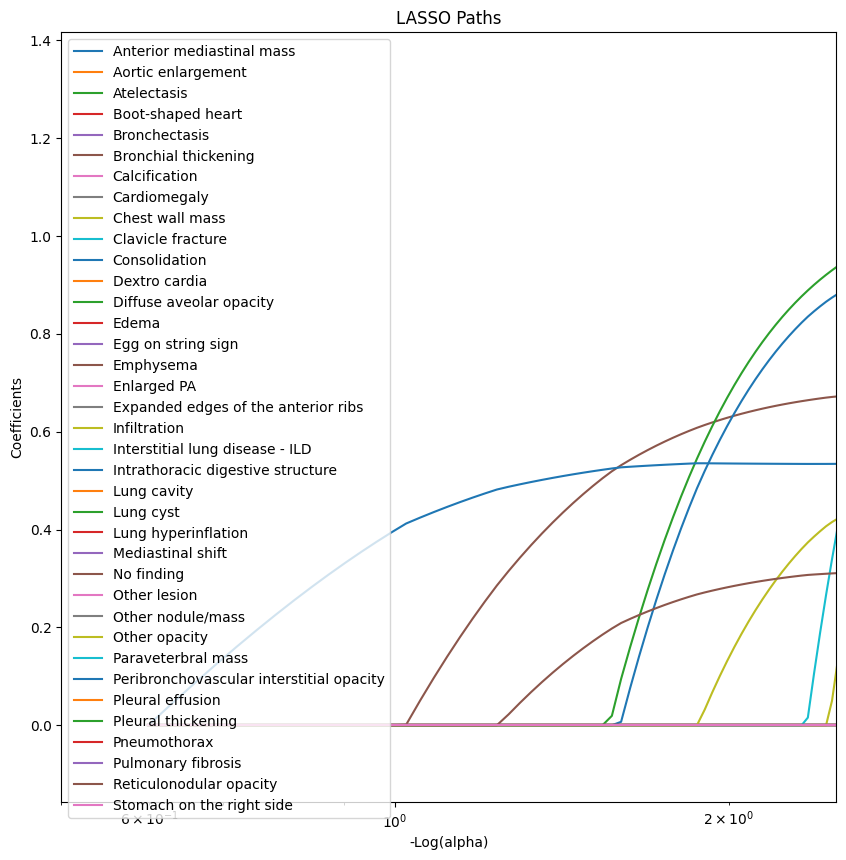

In [ ]:
m_log_alphas = -np.log10(lasso_cv.alphas_)
COEF = []
for coef in lasso_cv.path(X_, y_)[1]:
    COEF.append(coef)
Lasso_scores = pd.DataFrame(COEF).T
Lasso_scores.columns = Df.columns[1:-1]

plt.figure(figsize=(10, 10))
for j, coef in enumerate(lasso_cv.path(X_, y_)[1]):
    plt.plot(m_log_alphas, coef,label=Lasso_scores.columns[j])
    COEF.append(coef)

plt.xlabel('-Log(alpha)')
plt.xscale('log')
plt.ylabel('Coefficients')
plt.title('LASSO Paths')
plt.axis('tight')
plt.xlim(0.5, 2.5)
plt.legend(loc='upper left')
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(lasso_cv, prefit=True)
X_selected = sfm.transform(X_)
X_val_selected = sfm.transform(X_val)

In [ ]:
classifier.fit(X_selected, y_)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('selectkbest', SelectKBest(k=5)),
                ('logisticregression',
                 LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))])

In [ ]:
y_pred = classifier.predict(X_val_selected)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.52      0.46        69
           1       0.62      0.15      0.25        85
           2       0.59      0.85      0.70       174
           3       0.90      0.57      0.70        81

    accuracy                           0.59       409
   macro avg       0.63      0.52      0.53       409
weighted avg       0.63      0.59      0.56       409



In [ ]:
selected_feature_indices = np.where(sfm.get_support())[0]
selected_features = Df.iloc[:,1:-1].columns[selected_feature_indices]
coefficients = lasso_cv.coef_
print("Selected Features:", selected_features)
print("Feature Coefficients:", coefficients)

Selected Features: Index(['Bronchial thickening', 'Consolidation', 'Diffuse aveolar opacity',
       'Interstitial lung disease - ILD', 'Lung hyperinflation',
       'Other opacity', 'Peribronchovascular interstitial opacity',
       'Reticulonodular opacity'],
      dtype='object')
Feature Coefficients: [ 0.          0.          0.         -0.         -0.         -0.25237318
  0.          0.          0.          0.         -0.01832076  0.
 -0.09361089  0.         -0.          0.          0.          0.
  0.          0.17033597  0.          0.         -0.         -0.35877595
  0.          0.         -0.          0.         -0.22768998  0.
 -0.46486401  0.          0.          0.          0.         -0.51359094
  0.        ]


In [ ]:
X_selected_features = X_[:, selected_feature_indices]
selected_features_df = pd.DataFrame(X_selected_features, columns=selected_features)
selected_features_df.columns

Index(['Bronchial thickening', 'Consolidation', 'Diffuse aveolar opacity',
       'Interstitial lung disease - ILD', 'Lung hyperinflation',
       'Other opacity', 'Peribronchovascular interstitial opacity',
       'Reticulonodular opacity'],
      dtype='object')

Best alpha: 0.0050577544308782986


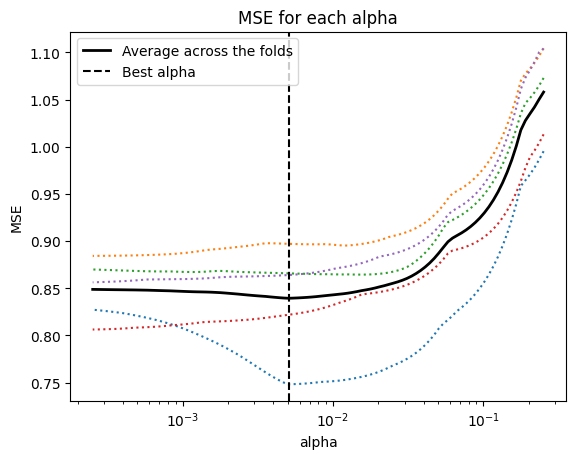

In [ ]:
lasso = model
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle=":")
plt.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

plt.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="Best alpha")

plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE for each alpha")

plt.legend()
print("Best alpha:", lasso_cv.alpha_)

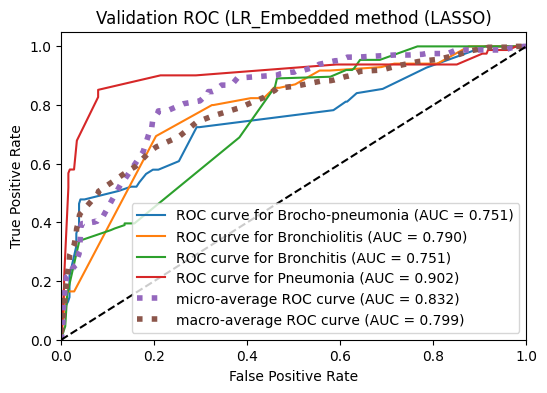

In [ ]:
classifier = pipe_LR
y_score = classifier.fit(X_selected, y_).predict_proba(X_val_selected)

label_binarizer = LabelBinarizer().fit(y_)
y_onehot_test = label_binarizer.transform(y_val)

fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC (LR_Embedded method (LASSO))')
plt.legend(loc="lower right")
plt.show()

# Embedded method (SHAP) (37→5 narrow down)

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.1 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
import shap

xgbc = XGBClassifier(random_state=SEED)

In [ ]:
ix_training, ix_test = [], []
for fold in cv.split(df):
    ix_training.append(fold[0]), ix_test.append(fold[1])

In [ ]:
SHAP_values_per_fold = []
for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
    X_train, X_test = X_[train_outer_ix, :], X_[test_outer_ix, :]
    y_train, y_test = y_[train_outer_ix], y_[test_outer_ix]

    model = xgbc
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    for SHAPs in shap_values:
        SHAP_values_per_fold.append(SHAPs)

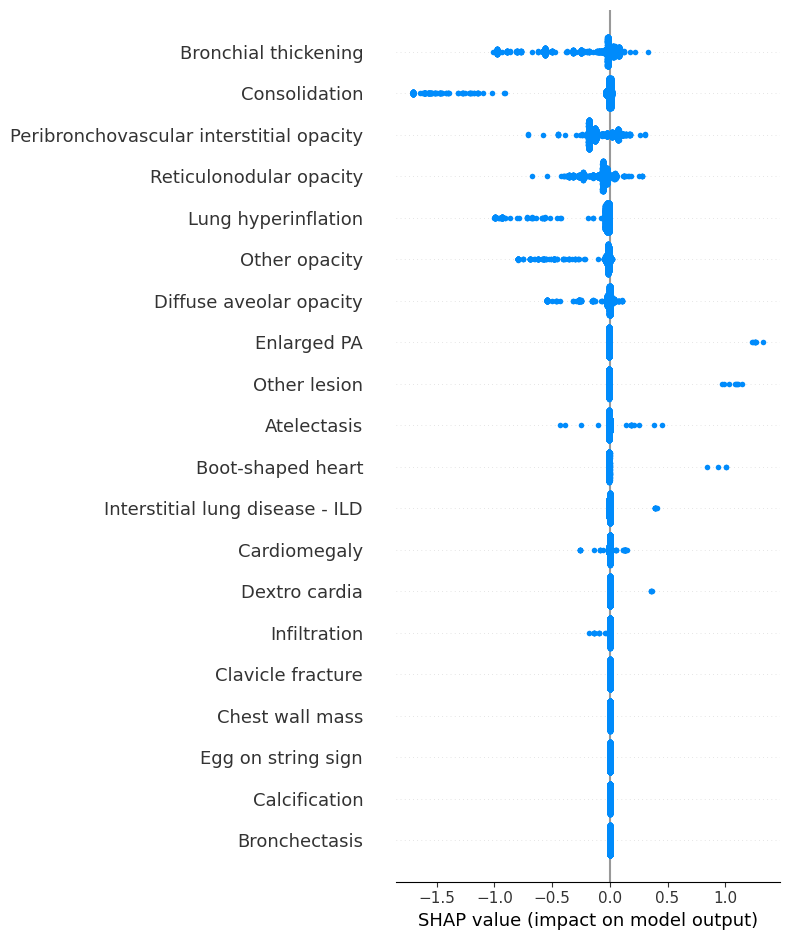

In [ ]:
SHAP_values_mean = np.mean(np.array(SHAP_values_per_fold), axis=2)
shap.summary_plot(np.array(SHAP_values_mean), Df.columns[1:-1])

In [ ]:
SHAP_feature_top5 = ['Bronchial thickening','Consolidation','Peribronchovascular interstitial opacity','Reticulonodular opacity','Lung hyperinflation']

In [ ]:
X_selected = X_[:, Df.columns[1:-1].isin(SHAP_feature_top5)]
X_val_selected = X_val[:, Df.columns[1:-1].isin(SHAP_feature_top5)]

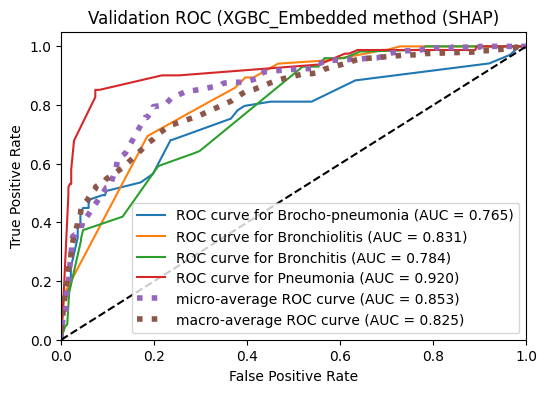

In [ ]:
classifier = xgbc
y_score = classifier.fit(X_selected, y_).predict_proba(X_val_selected)

label_binarizer = LabelBinarizer().fit(y_)
y_onehot_test = label_binarizer.transform(y_val)

fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC (XGBC_Embedded method (SHAP))')
plt.legend(loc="lower right")
plt.show()